# 6th attempt - RCNN

In [16]:
import numpy as np
import pandas as pd
from functions import *
from read_from_file_df import *
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [17]:
SIZE = 10
AMOUNT_BOARDS = 1000

In [18]:
gen = 2
name_df = f'{PATH_DF}\\{SIZE}-{AMOUNT_BOARDS}\\{SIZE}size_{AMOUNT_BOARDS}boards_{gen}gen_reverse'
reverse_df = pd.read_pickle(f'{name_df}.pkl')

In [19]:
new_columns = [f'Col_{i}' for i in range(gen*SIZE*SIZE)]
reverse_df_sort = reverse_df.sort_values(by = new_columns).reset_index(drop=True)
for i in reverse_df_sort.columns:
    reverse_df_sort[i] = reverse_df_sort[i].astype(int)

In [20]:
print("reverse df:", len(reverse_df))
print("reverse df sort:",len(reverse_df_sort))

reverse df: 41366
reverse df sort: 41366


In [21]:
# Step 1: Prepare Data
amount_features = len(reverse_df_sort.columns) - SIZE*SIZE #the previous boards
features = reverse_df_sort.iloc[:, :amount_features]
name_col = 'Col_' + str(amount_features + 1)  # Target: the first pixel in the board
target = reverse_df_sort[name_col]

# Step 2: Split Data
X_train_val, X_test, y_train_val, y_test = train_test_split(features, target, test_size=0.1, random_state=365)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=365)

print("len x train: ", len(X_train))
print("len x test: ",len(X_test))
print("len y train: ",len(y_train))
print("len y test: ",len(y_test))

len x train:  33506
len x test:  4137
len y train:  33506
len y test:  4137


In [22]:
X_train.shape

(33506, 100)

In [23]:
X_train_array = X_train.to_numpy()
y_train_array = y_train.to_numpy()

In [24]:
print(X_train_array.shape)
print(y_train_array.shape)

(33506, 100)
(33506,)


In [25]:
X_train_array = X_train_array.reshape((X_train.shape[0],SIZE,SIZE,1))
y_train_array = y_train_array.reshape((y_train.shape[0],1))

In [26]:
print(X_train_array.shape)
print(y_train_array.shape)

(33506, 10, 10, 1)
(33506, 1)


In [27]:
X_val_array = X_val.to_numpy()
X_val_array = X_val_array.reshape((X_val.shape[0],SIZE,SIZE,1))
y_val_array = y_val.to_numpy()
y_val_array = y_val_array.reshape((y_val.shape[0],1))

X_test_array = X_test.to_numpy()
X_test_array = X_test_array.reshape((X_test.shape[0],SIZE,SIZE,1))
y_test_array = y_test.to_numpy()
y_test_array = y_test_array.reshape((y_test.shape[0],1))

In [34]:
import tensorflow as tf
import numpy as np

# --- פרמטרים ---
SIZE = 10             # גודל הלוח
gen_data = gen - 1    # מספר הלוחות הרציפים בקלט
BATCH_SIZE = 32
EPOCHS = 3

# --- PREPROCESSING ---
# X_train_array.shape = (num_samples + gen_data, SIZE, SIZE, 1)
# y_train_array.shape = (num_samples, 1)  ← תא אחד בלבד (0 או 1)

num_samples = X_train_array.shape[0] - gen_data

X_train = np.zeros((num_samples, gen_data, SIZE, SIZE, 1), dtype='float32')
y_train = np.zeros((num_samples, 1), dtype='float32')  # רק תא אחד

for i in range(num_samples):
    X_train[i] = X_train_array[i:i+gen_data]   # רצף של gen_data לוחות
    y_train[i] = y_train_array[i]              # הפלט: תא אחד (0/1)

print("X_train shape:", X_train.shape)  # (num_samples, gen_data, SIZE, SIZE, 1)
print("y_train shape:", y_train.shape)  # (num_samples, 1)

# --- MODEL ---
model = tf.keras.Sequential([
    tf.keras.layers.ConvLSTM2D(
        filters=32,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        return_sequences=True,
        input_shape=(gen_data, SIZE, SIZE, 1)
    ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.ConvLSTM2D(
        filters=64,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        return_sequences=False
    ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # ← פלט יחיד בינארי
])

X_train shape: (33505, 1, 10, 10, 1)
y_train shape: (33505, 1)


In [35]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_6 (ConvLSTM2D)      │ (None, 1, 10, 10, 32)  │        38,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1, 10, 10, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)      │ (None, 10, 10, 64)     │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,697 (2.55 MB)

 Trainable params: 669,505 (2.55 MB)

 Non-trainable params: 192 (768.00 B)

In [36]:
# אימון
history = model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/5
838/838 ━━━━━━━━━━━━━━━━━━━━ 69s 75ms/step - accuracy: 0.8074 - loss: 0.4110 - val_accuracy: 0.8332 - val_loss: 0.3586
Epoch 2/5
838/838 ━━━━━━━━━━━━━━━━━━━━ 49s 58ms/step - accuracy: 0.8559 - loss: 0.3222 - val_accuracy: 0.8385 - val_loss: 0.3520
Epoch 3/5
838/838 ━━━━━━━━━━━━━━━━━━━━ 47s 56ms/step - accuracy: 0.8794 - loss: 0.2786 - val_accuracy: 0.8390 - val_loss: 0.3790
Epoch 4/5
838/838 ━━━━━━━━━━━━━━━━━━━━ 48s 57ms/step - accuracy: 0.9169 - loss: 0.2052 - val_accuracy: 0.8290 - val_loss: 0.4164
Epoch 5/5
838/838 ━━━━━━━━━━━━━━━━━━━━ 94s 72ms/step - accuracy: 0.9571 - loss: 0.1125 - val_accuracy: 0.8272 - val_loss: 0.5937


In [38]:
X_test = X_test_array.reshape((-1, gen_data, SIZE, SIZE, 1)).astype('float32')
y_test = y_test_array.astype('float32')

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8135 - loss: 0.6339
Test accuracy: 0.819


In [47]:
import numpy as np
from sklearn.metrics import confusion_matrix

def evaluate_model(model, X_test_array, y_test_array, gen_data, SIZE):
    """
    מעריך את ביצועי המודל ומציג טבלת Confusion Matrix ומדדים מסוכמים.
    """
    # עיבוד הנתונים
    X_test = X_test_array.reshape((-1, gen_data, SIZE, SIZE, 1)).astype('float32')
    y_test = y_test_array.reshape((-1, 1)).astype('float32')

    # חיזוי
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_binary)
    tn, fp, fn, tp = cm.ravel()

    # חישוב מדדים
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    acc = (tp + tn) / (tp + tn + fp + fn)

    # --- הדפסה בטבלה ---
    print("\n===== Evaluation Results =====")
    print("┌──────────────┬────────────┬────────────┐")
    print(f"│              │ Pred=Alive │ Pred=Dead  │")
    print("├──────────────┼────────────┼────────────┤")
    print(f"│ True=Alive   │ {tp:10d} │ {fn:10d} │")
    print(f"│ True=Dead    │ {fp:10d} │ {tn:10d} │")
    print("└──────────────┴────────────┴────────────┘")

    print("\n--- Performance Metrics ---")
    print(f"{'Accuracy':<12}: {acc:.3f}")
    print(f"{'Precision':<12}: {precision:.3f}")
    print(f"{'Recall':<12}: {recall:.3f}")
    print(f"{'F1-score':<12}: {f1:.3f}")


In [48]:
# יצירת סט בדיקה
num_samples_test = X_test_array.shape[0] - gen_data
X_test = np.zeros((num_samples_test, gen_data, SIZE, SIZE, 1), dtype='float32')
y_test = np.zeros((num_samples_test, 1), dtype='float32')

for i in range(num_samples_test):
    X_test[i] = X_test_array[i:i+gen_data]
    y_test[i] = y_test_array[i]

# הפעלת פונקציית ההערכה
results = evaluate_model(model, X_test, y_test, gen_data, SIZE)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step

===== Evaluation Results =====
┌──────────────┬────────────┬────────────┐
│              │ Pred=Alive │ Pred=Dead  │
├──────────────┼────────────┼────────────┤
│ True=Alive   │        499 │        443 │
│ True=Dead    │        305 │       2889 │
└──────────────┴────────────┴────────────┘

--- Performance Metrics ---
Accuracy    : 0.819
Precision   : 0.621
Recall      : 0.530
F1-score    : 0.572


X_test shape: (4136, 1, 10, 10, 1)
y_test shape: (4136, 10, 10, 1)
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7990 - loss: 0.5017

Test Loss: 0.5005 | Test Accuracy: 0.7999
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step

===== Evaluation Results =====
Total cells: 413600
True Positives (alive predicted alive): 0
True Negatives (dead predicted dead): 330856
False Positives (dead predicted alive): 0
False Negatives (alive predicted dead): 82744
--------------------------------
Accuracy : 0.7999
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000


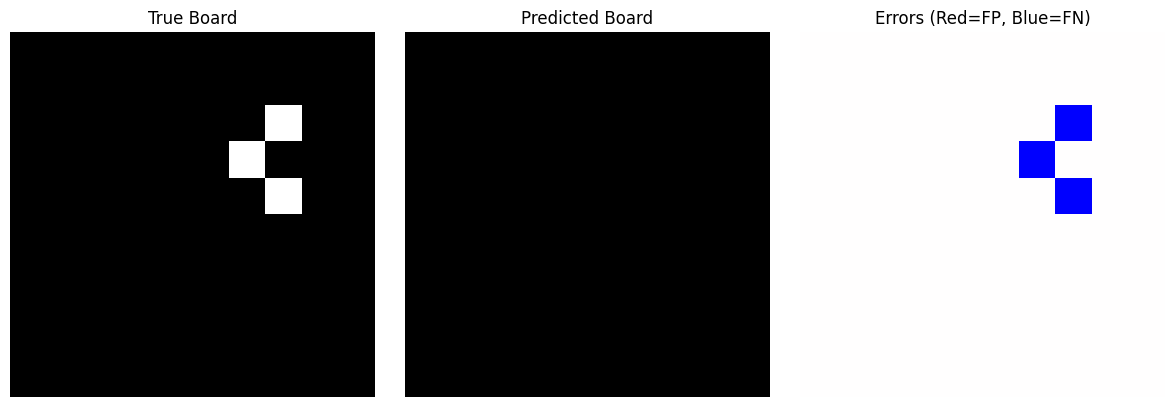

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# --- הכנת הנתונים לבדיקה ---
num_samples_test = X_test_array.shape[0] - gen_data

X_test = np.zeros((num_samples_test, gen_data, SIZE, SIZE, 1), dtype='float32')
y_test = np.zeros((num_samples_test, SIZE, SIZE, 1), dtype='float32')

for i in range(num_samples_test):
    X_test[i] = X_test_array[i:i+gen_data]
    y_test[i] = X_test_array[i+gen_data]

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# --- הערכת המודל ---
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


# --- פונקציית ניתוח מפורט ---
def evaluate_model_detailed(model, X_test, y_test, threshold=0.5, show_example=True):
    """
    פונקציה להצגת ביצועי המודל בפירוט עבור Game of Life הפוך
    """
    # חיזוי
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob >= threshold).astype(int)
    y_true = y_test.astype(int)

    # חישוב מדדים
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    TP = np.sum((y_true_flat == 1) & (y_pred_flat == 1))
    TN = np.sum((y_true_flat == 0) & (y_pred_flat == 0))
    FP = np.sum((y_true_flat == 0) & (y_pred_flat == 1))
    FN = np.sum((y_true_flat == 1) & (y_pred_flat == 0))

    total_cells = len(y_true_flat)
    accuracy = (TP + TN) / total_cells
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print("\n===== Evaluation Results =====")
    print(f"Total cells: {total_cells}")
    print(f"True Positives (alive predicted alive): {TP}")
    print(f"True Negatives (dead predicted dead): {TN}")
    print(f"False Positives (dead predicted alive): {FP}")
    print(f"False Negatives (alive predicted dead): {FN}")
    print("--------------------------------")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1_score:.4f}")
    print("================================")

    # הצגה גרפית
    if show_example:
        idx = np.random.randint(0, len(X_test))
        y_t = y_true[idx].squeeze()
        y_p = y_pred[idx].squeeze()

        diff_map = np.zeros_like(y_t, dtype=int)
        diff_map[(y_t == 0) & (y_p == 1)] = 1   # FP → אדום
        diff_map[(y_t == 1) & (y_p == 0)] = -1  # FN → כחול

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.title("True Board")
        plt.imshow(y_t, cmap='gray')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.title("Predicted Board")
        plt.imshow(y_p, cmap='gray')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.title("Errors (Red=FP, Blue=FN)")
        plt.imshow(diff_map, cmap='bwr', vmin=-1, vmax=1)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return {
        "TP": TP, "TN": TN, "FP": FP, "FN": FN,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }


# --- קריאה לפונקציה ---
results = evaluate_model_detailed(model, X_test, y_test)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8135 - loss: 0.6339
Test accuracy: 0.819
